## Imports 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%config InlineBackend.figure_format='retina'

https://www.kaggle.com/c/bike-sharing-demand/data

## Reading input data

In [2]:
dataset = pd.read_csv('train_bike.csv', header=0,  sep=',',
                      parse_dates=['datetime'], index_col='datetime').drop(
    columns=['casual', 'registered']
)

## Train model on `(train_year, train_month)` compute $R^2$ score on `(test_year, test_month)`

In [3]:
def measure(train_year, train_month, test_year, test_month):
    train: pd.DataFrame = dataset.loc[
        lambda df: (df.index.year == train_year) & (df.index.month == train_month)
    ]
    test: pd.DataFrame = dataset.loc[
        lambda df: (df.index.year == test_year) & (df.index.month == test_month)
    ]

    from sklearn.ensemble import HistGradientBoostingRegressor as Model
    from sklearn.metrics import r2_score

    def time_features(input_df):
        return input_df.assign(
            month = lambda df: df.index.month,
            day = lambda df: df.index.day,
            hour = lambda df: df.index.hour,
        )

    model = Model()
    model.fit(train.drop(columns='count').pipe(time_features), train['count'])
    return r2_score(test['count'], model.predict(test.drop(columns='count').pipe(time_features)))

## Compute score on all causal combinations of `(train_year, train_month, test_year, test_month)`

In [4]:
records = []
for train_month in range(1, 12 + 1):
    for test_month in range(train_month + 1, 12 + 1):
        records.append({
            'train_month': train_month,
            'test_month': test_month,
            'score': measure(2011, train_month, 2011, test_month)
        })
df = pd.DataFrame(records)

## Score decay heatmap

<AxesSubplot:xlabel='test_month', ylabel='train_month'>

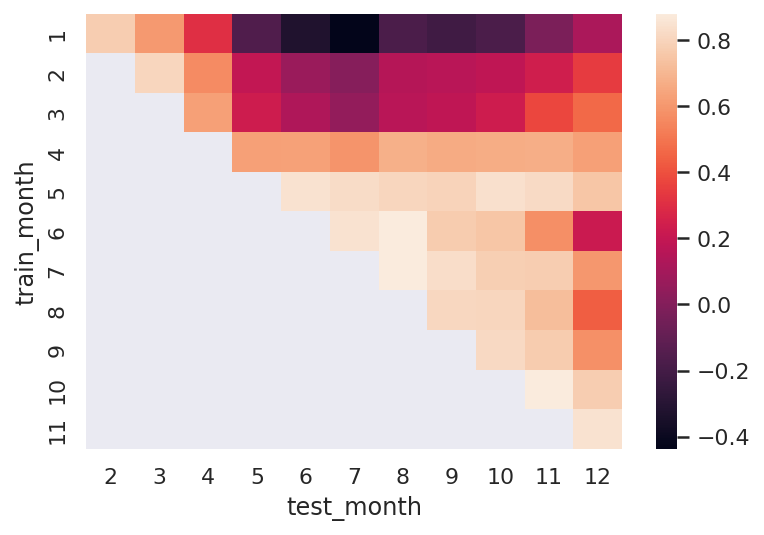

In [5]:
sns.heatmap(
    df.pivot(index='train_month', columns='test_month', values='score')
)

## Score decay line plot grid

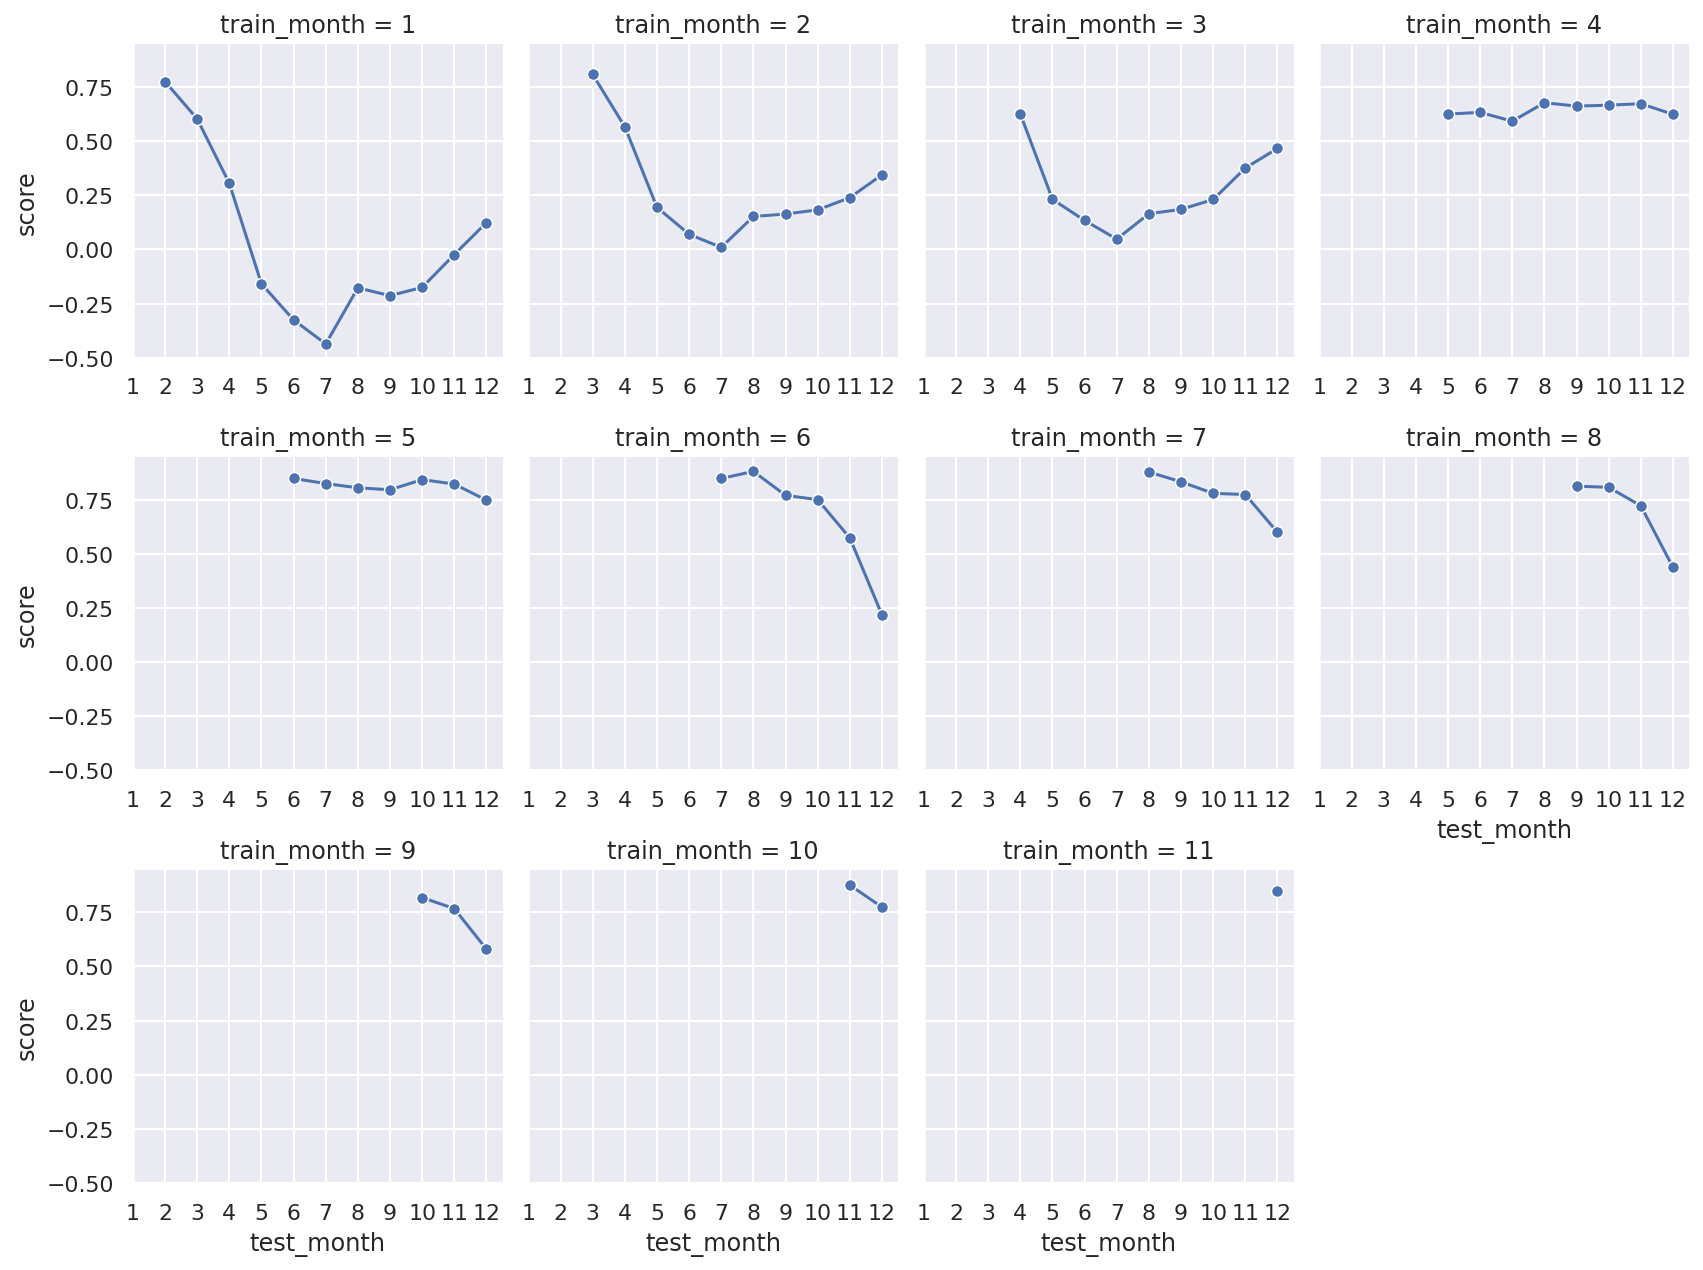

In [6]:
g = (sns
 .FacetGrid(df, col='train_month', col_wrap=4)
 .map(sns.lineplot, 'test_month', 'score', marker='o')
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
    ax.set_xticks(range(1, 12+1))

## Score with no retraining (just use the 1st model) 

<AxesSubplot:xlabel='test_month'>

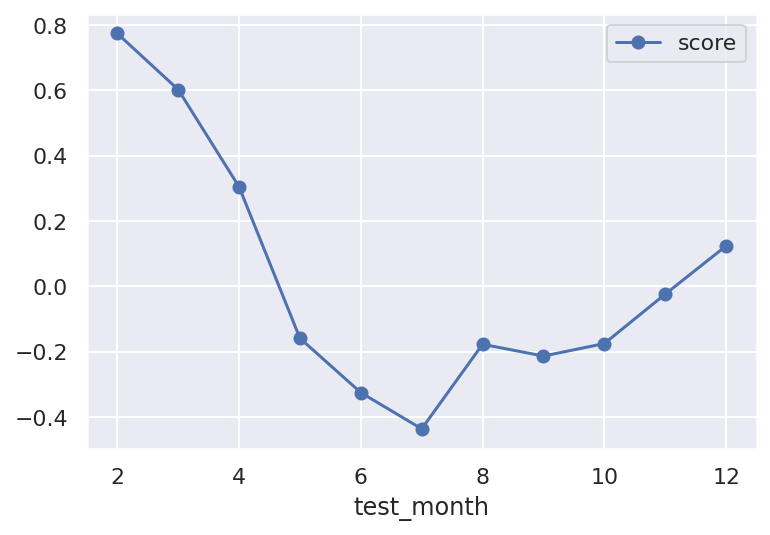

In [7]:
(df
 .loc[lambda df: df['train_month'] == 1]
 .loc[lambda df: df['test_month'].isin(range(1, 12 + 1))]
).plot(x='test_month', y='score', marker='o')

## Score retraining every 3 months

,train_month,test_month,score
0,1,2,0.774460
1,1,3,0.602656
2,1,4,0.304800
30,4,5,0.624518
31,4,6,0.632447
32,4,7,0.591708
51,7,8,0.877253
52,7,9,0.831926
53,7,10,0.778792
63,10,11,0.875447


<AxesSubplot:xlabel='test_month'>

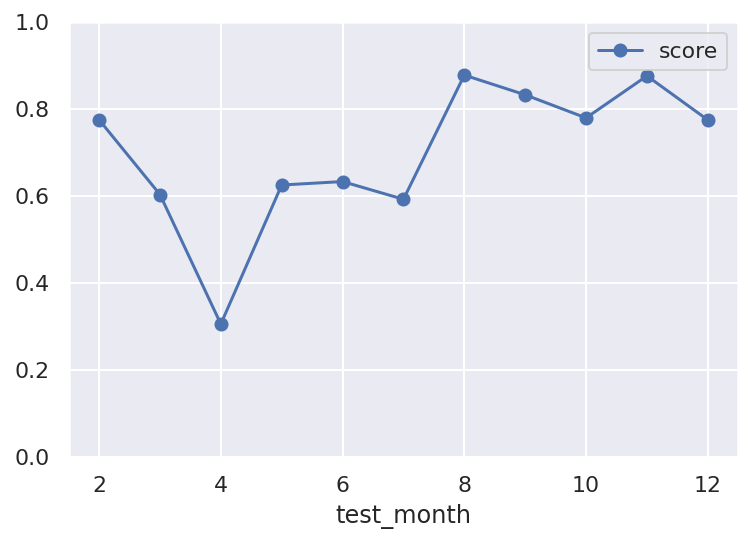

In [8]:
pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 3)
]).pipe(lambda df: (display(df), df)[1]).plot(x='test_month', y='score', marker='o', ylim=(0,1))

## Score retraining every 2 months

,train_month,test_month,score
0,1,2,0.774460
1,1,3,0.602656
21,3,4,0.624701
22,3,5,0.231095
38,5,6,0.847629
39,5,7,0.823819
51,7,8,0.877253
52,7,9,0.831926
60,9,10,0.817807
61,9,11,0.767109


<AxesSubplot:xlabel='test_month'>

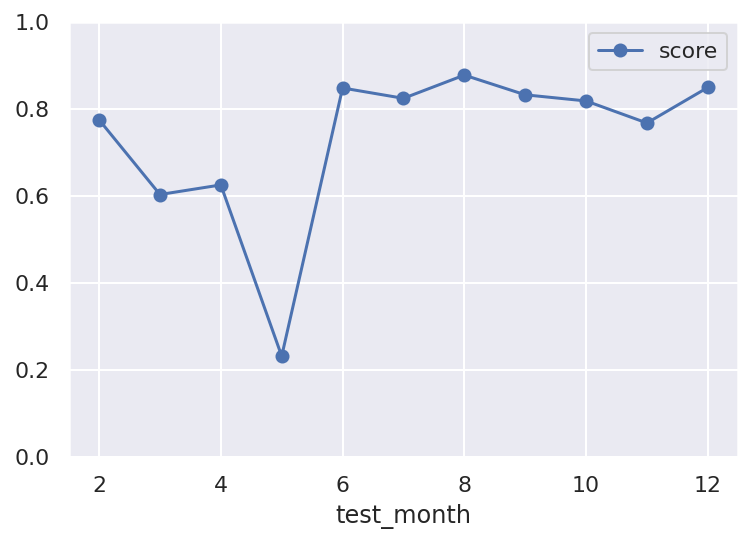

In [9]:
(pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 2)
])
 .drop_duplicates(subset='test_month', keep='last')
 .pipe(lambda df: (display(df), df)[1])
 .plot(x='test_month', y='score', marker='o', ylim=(0,1))
)

## Score retraining every 1 month 

,train_month,test_month,score
0,1,2,0.774460
11,2,3,0.807464
21,3,4,0.624701
30,4,5,0.624518
38,5,6,0.847629
45,6,7,0.847367
51,7,8,0.877253
56,8,9,0.811767
60,9,10,0.817807
63,10,11,0.875447


<AxesSubplot:xlabel='test_month'>

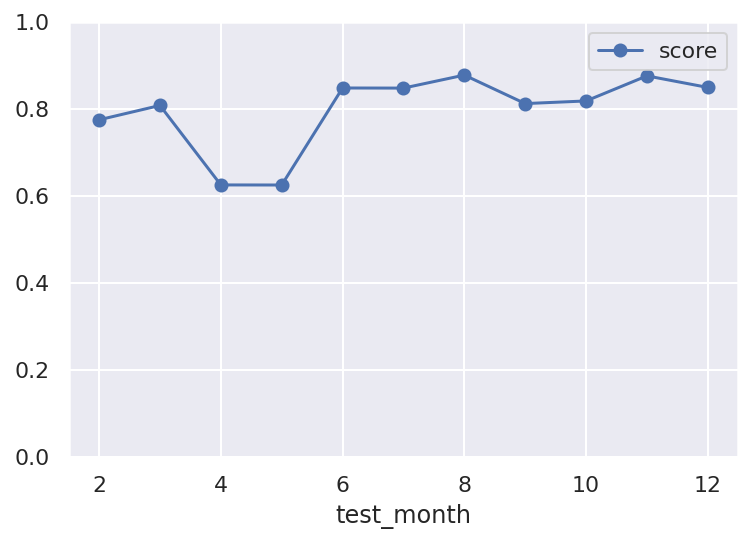

In [10]:
(pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 1)
])
 .drop_duplicates(subset='test_month', keep='last')
 .pipe(lambda df: (display(df), df)[1])
 .plot(x='test_month', y='score', marker='o', ylim=(0,1))
)

## All retraining regimes together

Text(0.5, 1.0, 'Retraining every 1 months')

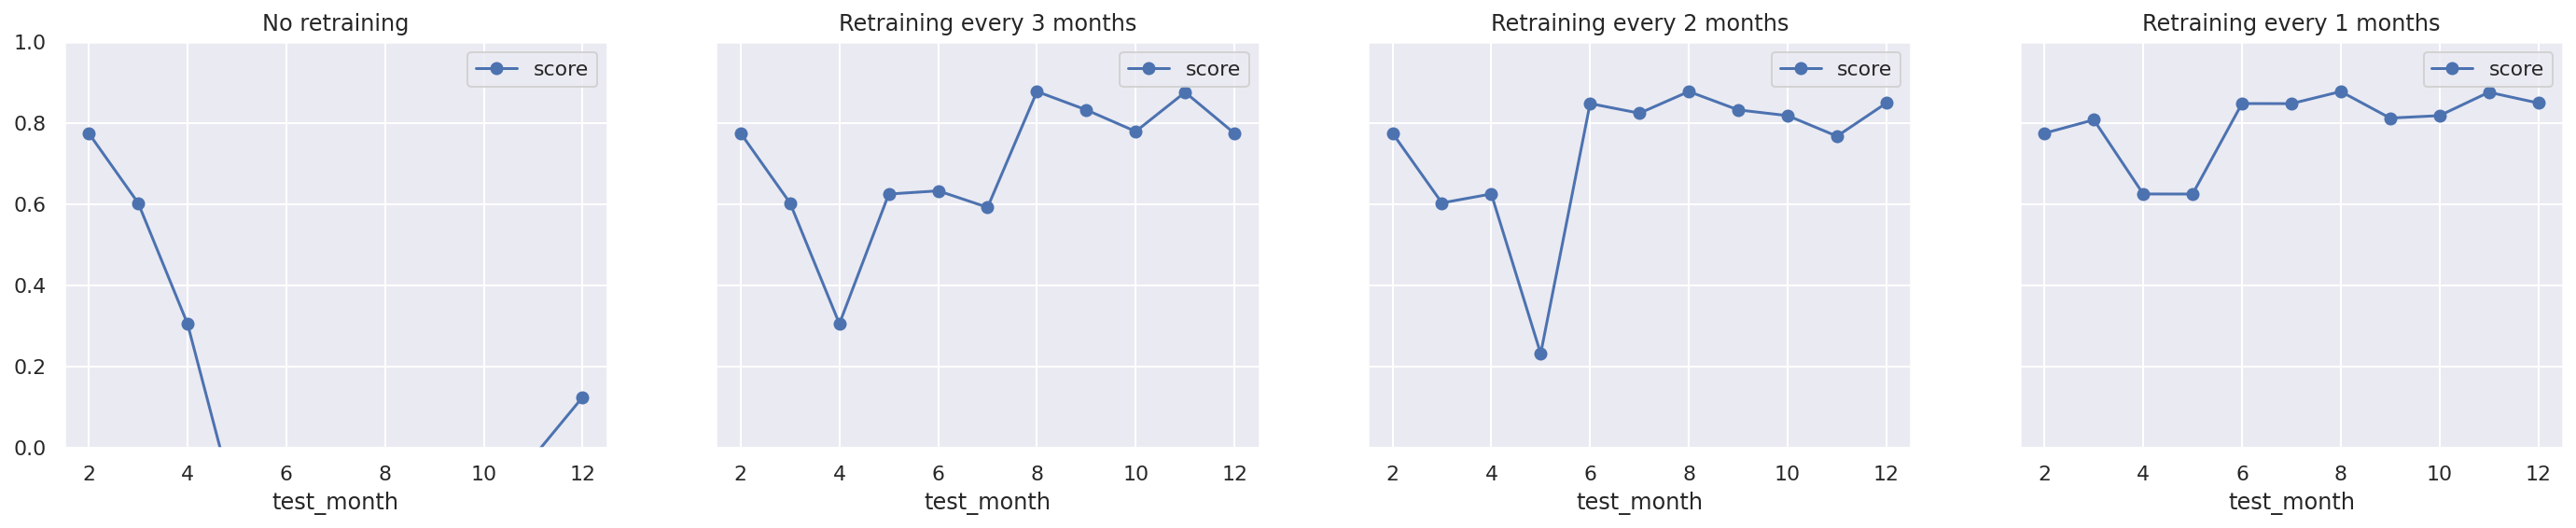

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24, 4), sharey=True)
axes = np.ravel(axes)

(df
 .loc[lambda df: df['train_month'] == 1]
 .loc[lambda df: df['test_month'].isin(range(1, 12 + 1))]
).plot(x='test_month', y='score', marker='o', ax=axes[0])
axes[0].set_title('No retraining')

pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 3)
]).plot(x='test_month', y='score', marker='o', ylim=(0,1), ax=axes[1])
axes[1].set_title('Retraining every 3 months')

(pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 2)
])
 .drop_duplicates(subset='test_month', keep='last')
 .plot(x='test_month', y='score', marker='o', ylim=(0,1), ax=axes[2])
)
axes[2].set_title('Retraining every 2 months')

(pd.concat([
    (df
     .loc[lambda df: df['train_month'] == i]
     .loc[lambda df: df['test_month'].isin(range(i+1, i+1+3))]
    ) for i in np.arange(1, 12, 1)
])
 .drop_duplicates(subset='test_month', keep='last')
 .plot(x='test_month', y='score', marker='o', ylim=(0,1), ax=axes[3])
)
axes[3].set_title('Retraining every 1 months')

But should we train on all data on only the last month's data?

Let's say that for performance reasons we can only use 1 month's worth of data